In [1]:
import os

import cv2
import numpy as np
import tiffcapture as tc

import time

from matplotlib import pyplot as pt
from tifffile import imsave

%matplotlib inline

In [2]:
def get_video(path, to_rgb=False):
    """
    Read TIFF file containing multiple stacks (a video)
    and return sequential array of frame encoded as
    multidimensional array
    """
    
    tif = tc.opentiff(path)
    
    ## first image
    _, first_img = tif.retrieve()
    if to_rgb:
        first_img = cv2.cvtColor(first_img,cv2.COLOR_GRAY2RGB)

    ## slices
    pics = [first_img]

    for slide in tif:
        # convert grayscale to RGB
        if to_rgb:
            slide = cv2.cvtColor(slide, cv2.COLOR_GRAY2RGB)
        pics.append(slide)
    
    return pics

In [3]:
def infer_shift(position, path, search_space=(200, 200), verbose=True):
    
    t1 = time.time()
    if verbose:
        print("inferring shift for position %s" % position)
    
    if (search_space[0] % 2 != 0) or (search_space[1] % 2 != 0):
        print("  Search space has to be even for both dimensions")
        return None
    else:
    
        path_t1 = os.path.join(path, "out-focus/before/bfxy%sc1.tif" % position)
        path_t2 = os.path.join(path, "out-focus/after/bfxy%sc1.tif" % position)
    
        ## extract slides
        bf = get_video(path_t1)
        f1 = bf[len(bf) - 1]

        af = get_video(path_t2)
        f2 = af[0]

        fs = bf + af
    
        ## calculate absolute difference for various shifting configurations

        x1 = search_space[0]
        x2 = search_space[0]
        y1 = search_space[1]
        y2 = search_space[1]
        mid = f1.shape[0] // 2, f1.shape[1] // 2
        absdiffs = np.zeros((search_space[0] + 1, search_space[1] + 1))


        f1sub = f1[(mid[0] - x1):(mid[0] + x2), (mid[1] - y1):(mid[1] + y2)]

    for xdiff in range(-int(search_space[0] / 2), int(search_space[0] / 2) + 1):
        for ydiff in range(-int(search_space[1] / 2), int(search_space[1] / 2) + 1):
            f2sub = f2[(mid[0] - x1 + xdiff):(mid[0] + x2 + xdiff), 
                       (mid[1] - y1 + ydiff):(mid[1] + y2 + ydiff)]
    
            absdiffs[xdiff + int(search_space[0] / 2)][ydiff + int(search_space[1] / 2)] = \
                np.sum(cv2.absdiff(f1sub, f2sub).ravel())
        
        
    ## calculate shift based on calibration data

    x = np.argmin(absdiffs) // absdiffs.shape[0]
    y = np.argmin(absdiffs) % absdiffs.shape[0]
    
    """
    True shift is the opposite of coordinate encoded in absdiff
    
    Let X2 the second picture and X1 the first picture.
    If the sub-picture of first slide of X2 centered at (c1 + s1, c2 + s2)
    fits the most with the sub-picture of the last slide of X1
    centered at (c1, c2) then the pictures shift by (-s1, -s2)
    upon treatment
    """
    diff = -(x - search_space[0] / 2), -(y - search_space[1] / 2)

    if verbose:
        print("  inferred shift (%d, %d)" % diff)
        print("  elapsed time: %f" % (time.time() - t1))
    else:
        print("%s, %d, %d" % (position, diff[0], diff[1]))
    
    return diff

In [4]:
def infer_shift_range(path, first=1, last=63, search_space=(200, 200), verbose=True):
    for pos in range(first, last + 1):
        
        t1 = time.time()
        if pos < 10:
            posstr = "0%d" % pos
            this_path = path % posstr
            if verbose:
                print("copying position %s" % posstr)
            infer_shift(position=posstr, path=this_path, search_space=search_space, verbose=verbose)
        else:
            if verbose:
                print("copying position %d" % pos)
            this_path = path % str(pos)
            infer_shift(position=str(pos), path=this_path, search_space=search_space, verbose=verbose)
        if verbose:
            print(" elapsed time: %f" % (time.time() - t1))

In [5]:
def correct_shifts(path="../test/eli-new-unsync-bf-%s/", highest_shift=30, pos_start=1, pos_end=63):

    positions = list(range(pos_end + 1))[pos_start:]
    for pos in positions:
        if pos < 10:
            pst = "0%d" % pos
        else:
            pst = str(pos)
        
        t1 = time.time()
        print("correcting frames for position %s" % pst)

        path = path % pst

        diff = infer_shift(pst, path, verbose=False)
        print("    Inferred diff " + str(diff))
    
        if (abs(diff[0]) == 0) and (abs(diff[1]) == 0):
            print("     Perfect alignment, no frame adjustment will be done")
    
        elif (abs(diff[0]) < highest_shift) and (abs(diff[1]) < highest_shift):

            casp = os.path.join(path, "caspase/caspasexy%sc1.tif" % pst)
            pi1 = os.path.join(path, "pi/before/pi_in-focusxy%sc1.tif" % pst)
            pi2 = os.path.join(path, "pi/after/pixy%sc1.tif" % pst)
            in1 = os.path.join(path, "in-focus/before/bf_in-focusxy%sc1c1.tif" % pst)
            in2 = os.path.join(path, "in-focus/after/bf_in-focusxy%sc1.tif" % pst)
            out1 = os.path.join(path, "out-focus/before/bfxy%sc1.tif" % pst)
            out2 = os.path.join(path, "out-focus/after/bfxy%sc1.tif" % pst)

            caspv = get_video(casp)
            pi1v = get_video(pi1)
            pi2v = get_video(pi2)
            in1v = get_video(in1)
            in2v = get_video(in2)
            out1v = get_video(out1)
            out2v = get_video(out2)

            print("    Video importing done. Inferring shift and adjusting frames")

            diff = int(diff[0]), int(diff[1])

            if abs(diff[0]) != 0:
                caspv_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in caspv]
                pi2v_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in pi2v]
                in2v_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in in2v]
                out2v_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in out2v]
        
                pi1v_cropped = [sld[:diff[0],:] if diff[0] < 0 else sld[diff[0]:,:] for sld in pi1v]
                in1v_cropped = [sld[:diff[0],:] if diff[0] < 0 else sld[diff[0]:,:] for sld in in1v]
                out1v_cropped = [sld[:diff[0],:] if diff[0] < 0 else sld[diff[0]:,:] for sld in out1v]
            
            if abs(diff[1]) != 0:
        
                caspv_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in caspv_cropped]
                pi2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in pi2v_cropped]
                in2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in in2v_cropped]
                out2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in out2v_cropped]
        
                pi1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in pi1v_cropped]
                in1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in in1v_cropped]
                out1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in out1v_cropped]

            print("    Adjustment done. Writing results...")

            imsave(casp, np.array(caspv_cropped))
            imsave(pi1, np.array(pi1v_cropped))
            imsave(pi2, np.array(pi2v_cropped))
            imsave(in1, np.array(in1v_cropped))
            imsave(in2, np.array(in2v_cropped))
            imsave(out1, np.array(out1v_cropped))
            imsave(out2, np.array(out2v_cropped))

            print("time elapsed: %f" % (time.time() - t1))
        else:
            print("Inferred shift too large")

In [28]:
# TODO run

infer_shift_range("../test/eli-new-unsync-bf-%s/", 1, 63, verbose=False)

## Non-functional pipeline and extra plotting (for thesis etc)

In [35]:
position = "26"
# path = "../test/eli-new-unsync-bf-%s/out-focus/" % position
path = "../../test/eli-new-unsync-bf-%s/out-focus/" % position
path_t1 = os.path.join(path, "before/bfxy%sc1.tif" % position)
path_t2 = os.path.join(path, "after/bfxy%sc1.tif" % position)

In [36]:
## extract slides

bf = get_video(path_t1)
f1 = bf[len(bf) - 1]

af = get_video(path_t2)
f2 = af[0]

fs = bf + af

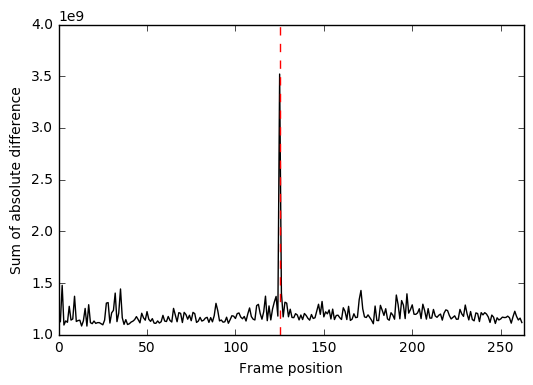

In [37]:
## TEST

## check slide-wise sum of absolute difference

absdiffs = []
for i in range(len(fs) - 7):
    prv = fs[i]
    nxt = fs[i + 1]
    
    absdiffs.append(np.sum(cv2.absdiff(prv, nxt).ravel()))
    
pt.plot(range(len(absdiffs)), absdiffs, c="black")
# pt.title("Pixel difference between consecutive frames (%s)" % position)
pt.xlabel("Frame position")
pt.ylabel("Sum of absolute difference")
pt.axvline(21 * 6 - 1, c='red', ls="--")
pt.xlim(0, 263)

pt.show()

In [40]:
##  TEST

## calculate absolute difference for various shifting configurations

x1 = 200
x2 = 200
y1 = 200
y2 = 200
mid = f1.shape[0] // 2, f1.shape[1] // 2
absdiffs = np.zeros((201, 201))


f1sub = f1[(mid[0] - x1):(mid[0] + x2), (mid[1] - y1):(mid[1] + y2)]

for xdiff in range(-100, 101):
    for ydiff in range(-100, 101):
        f2sub = f2[(mid[0] - x1 + xdiff):(mid[0] + x2 + xdiff), 
                   (mid[1] - y1 + ydiff):(mid[1] + y2 + ydiff)]
    
        absdiffs[xdiff + 100][ydiff + 100] = np.sum(cv2.absdiff(f1sub, f2sub).ravel())
        
        
## calculate shift based on calibration data

x = np.argmin(absdiffs) // absdiffs.shape[0]
y = np.argmin(absdiffs) % absdiffs.shape[0]
diff = x - 100, y - 100

print("inferred shift (%d, %d)" % diff)

inferred shift (-8, -5)


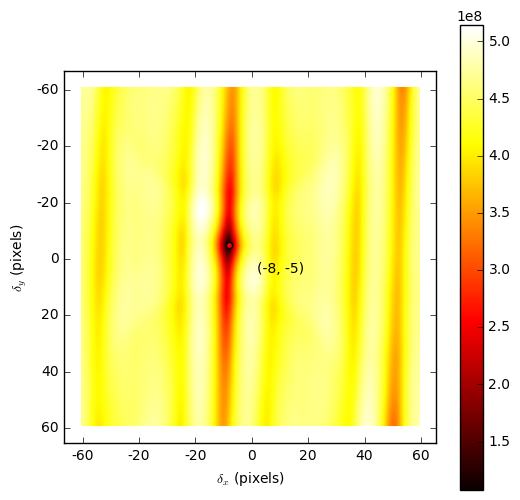

In [67]:
## TEST
## visualize difference as heatmap

fig, ax = pt.subplots()

absdiffsc = absdiffs.copy()
absdiffsc = absdiffsc[40:160, 40:160]
hmp = ax.imshow(absdiffsc.T, cmap="hot", label="absolute difference")

# Add colorbar, make sure to specify tick locations to match desired ticklabels

cbar = fig.colorbar(hmp)
ax.set_xticklabels([0, -60, -20, -20, 0, 20, 40, 60])
ax.set_yticklabels([0, -60, -20, -20, 0, 20, 40, 60])
pt.scatter(x - 40, y - 40, c="r")
ax.annotate("(%d, %d)" % (x - 100, y - 100), (x - 30, y - 30))

# pt.title("Abs. diff. value for different shift configs (%s)" % position)
pt.xlabel("$\delta_x$ (pixels)")
pt.ylabel("$\delta_y$ (pixels)")

fig.set_size_inches(6, 6)


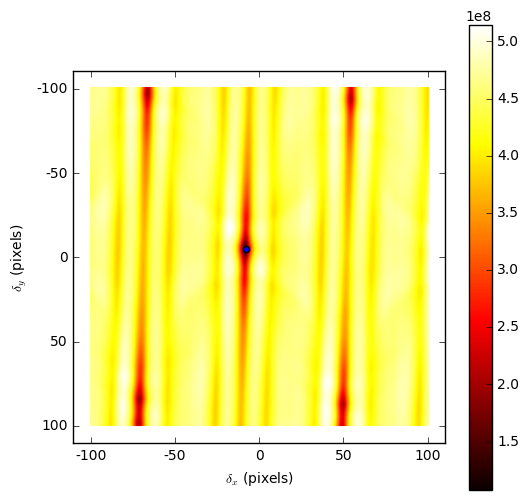

In [58]:
## TEST
## visualize difference as heatmap

fig, ax = pt.subplots()

hmp = ax.imshow(absdiffs.T, cmap="hot", label="absolute difference")

# Add colorbar, make sure to specify tick locations to match desired ticklabels

cbar = fig.colorbar(hmp)
ax.set_xticklabels([0, -100, -50, 0, 50, 100])
ax.set_yticklabels([0, -100, -50, 0, 50, 100])
# pt.setxticks([-100, -50, 0, 50, 100])
pt.scatter(x, y)
# pt.legend()

# pt.title("Abs. diff. value for different shift configs (%s)" % position)
pt.xlabel("$\delta_x$ (pixels)")
pt.ylabel("$\delta_y$ (pixels)")
#legend

fig.set_size_inches(6, 6)


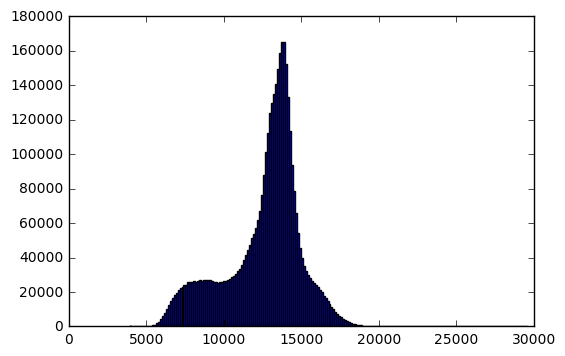

In [41]:
## channel histogram for f2

pt.hist(f2.ravel(), bins=200)
pt.show()

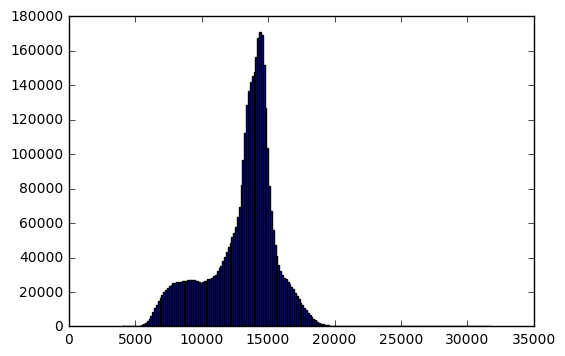

In [42]:
## channel histogram for f1

pt.hist(f1.ravel(), bins=200)
pt.show()

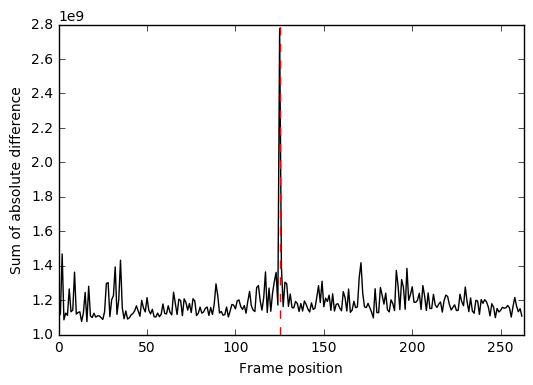

In [26]:
## check slide-wise sum of absolute difference

absdiffs = []
for i in range(len(fs) - 7):
    prv = fs[i]
    nxt = fs[i + 1]
    
    absdiffs.append(np.sum(cv2.absdiff(prv, nxt).ravel()))
    
pt.plot(range(len(absdiffs)), absdiffs, c="black")
# pt.title("Pixel difference between consecutive frames (%s)" % position)
pt.xlabel("Frame position")
pt.ylabel("Sum of absolute difference")
pt.axvline(21 * 6 - 1, c='red', ls="--")
pt.xlim(0, 263)

pt.show()

In [27]:
## calculate absolute difference for various shifting configurations

x1 = 200
x2 = 200
y1 = 200
y2 = 200
mid = f1.shape[0] // 2, f1.shape[1] // 2
absdiffs = np.zeros((201, 201))


f1sub = f1[(mid[0] - x1):(mid[0] + x2), (mid[1] - y1):(mid[1] + y2)]

for xdiff in range(-100, 101):
    for ydiff in range(-100, 101):
        f2sub = f2[(mid[0] - x1 + xdiff):(mid[0] + x2 + xdiff), 
                   (mid[1] - y1 + ydiff):(mid[1] + y2 + ydiff)]
    
        absdiffs[xdiff + 100][ydiff + 100] = np.sum(cv2.absdiff(f1sub, f2sub).ravel())
        
        
## calculate shift based on calibration data

x = np.argmin(absdiffs) // absdiffs.shape[0]
y = np.argmin(absdiffs) % absdiffs.shape[0]
diff = x - 100, y - 100

print("inferred shift (%d, %d)" % diff)

inferred shift (0, 0)


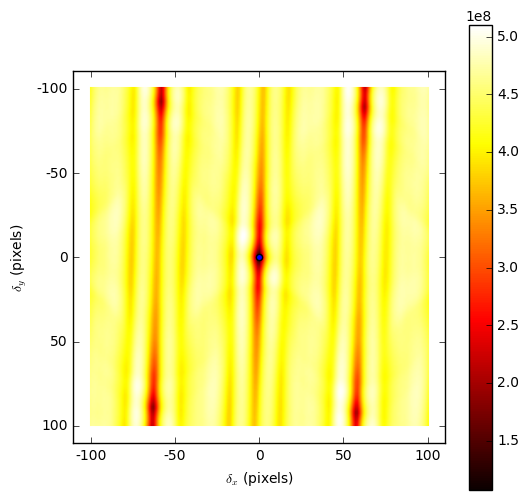

In [29]:
## visualize difference as heatmap

fig, ax = pt.subplots()

hmp = ax.imshow(absdiffs.T, cmap="hot", label="absolute difference")

# Add colorbar, make sure to specify tick locations to match desired ticklabels

cbar = fig.colorbar(hmp)
ax.set_xticklabels([0, -100, -50, 0, 50, 100])
ax.set_yticklabels([0, -100, -50, 0, 50, 100])
# pt.setxticks([-100, -50, 0, 50, 100])
pt.scatter(x, y)
# pt.legend()

# pt.title("Abs. diff. value for different shift configs (%s)" % position)
pt.xlabel("$\delta_x$ (pixels)")
pt.ylabel("$\delta_y$ (pixels)")
#legend

fig.set_size_inches(6, 6)


## Functional Pipeline

In [30]:
# TEST
highest_shift = 30

positions = [26]
for pos in positions:
    if pos < 10:
        pst = "0%d" % pos
    else:
        pst = str(pos)
        
    t1 = time.time()
    print("correcting frames for position %s" % pst)

    path = "../test/eli-new-unsync-bf-%s/" % pst

    diff = infer_shift(pst, path, verbose=False)
    print("    Inferred diff " + str(diff))
    
    if (abs(diff[0]) == 0) and (abs(diff[1]) == 0):
        print("     Perfect alignment, no frame adjustment will be done")
    
    elif (abs(diff[0]) < highest_shift) and (abs(diff[1]) < highest_shift):

        casp = os.path.join(path, "caspase/caspasexy%sc1.tif" % pst)
        pi1 = os.path.join(path, "pi/before/pi_in-focusxy%sc1.tif" % pst)
        pi2 = os.path.join(path, "pi/after/pixy%sc1.tif" % pst)
        in1 = os.path.join(path, "in-focus/before/bf_in-focusxy%sc1c1.tif" % pst)
        in2 = os.path.join(path, "in-focus/after/bf_in-focusxy%sc1.tif" % pst)
        out1 = os.path.join(path, "out-focus/before/bfxy%sc1.tif" % pst)
        out2 = os.path.join(path, "out-focus/after/bfxy%sc1.tif" % pst)

        caspv = get_video(casp)
        pi1v = get_video(pi1)
        pi2v = get_video(pi2)
        in1v = get_video(in1)
        in2v = get_video(in2)
        out1v = get_video(out1)
        out2v = get_video(out2)

        print("    Video importing done. Inferring shift and adjusting frames")

        diff = int(diff[0]), int(diff[1])

        if abs(diff[0]) != 0:
            caspv_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in caspv]
            pi2v_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in pi2v]
            in2v_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in in2v]
            out2v_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in out2v]
        
            pi1v_cropped = [sld[:diff[0],:] if diff[0] < 0 else sld[diff[0]:,:] for sld in pi1v]
            in1v_cropped = [sld[:diff[0],:] if diff[0] < 0 else sld[diff[0]:,:] for sld in in1v]
            out1v_cropped = [sld[:diff[0],:] if diff[0] < 0 else sld[diff[0]:,:] for sld in out1v]
            
        if abs(diff[1]) != 0:
        
            caspv_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in caspv_cropped]
            pi2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in pi2v_cropped]
            in2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in in2v_cropped]
            out2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in out2v_cropped]
        
            pi1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in pi1v_cropped]
            in1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in in1v_cropped]
            out1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in out1v_cropped]

        print("    Adjustment done. Writing results...")

        imsave(casp, np.array(caspv_cropped))
        imsave(pi1, np.array(pi1v_cropped))
        imsave(pi2, np.array(pi2v_cropped))
        imsave(in1, np.array(in1v_cropped))
        imsave(in2, np.array(in2v_cropped))
        imsave(out1, np.array(out1v_cropped))
        imsave(out2, np.array(out2v_cropped))

        print("time elapsed: %f" % (time.time() - t1))
    else:
        print("Inferred shift too large")

correcting frames for position 26
26, 0, 0
    Inferred diff (-0.0, -0.0)
     Perfect alignment, no frame adjustment will be done


In [46]:
highest_shift = 30

positions = list(np.array(range(63)) + 1)
for pos in positions:
    if pos < 10:
        pst = "0%d" % pos
    else:
        pst = str(pos)
        
    t1 = time.time()
    print("correcting frames for position %s" % pst)

    path = "../test/eli-new-unsync-bf-%s/" % pst

    diff = infer_shift(pst, path, verbose=False)
    print("    Inferred diff " + str(diff))
    
    if (abs(diff[0]) == 0) and (abs(diff[1]) == 0):
        print("     Perfect alignment, no frame adjustment will be done")
    
    elif (abs(diff[0]) < highest_shift) and (abs(diff[1]) < highest_shift):

        casp = os.path.join(path, "caspase/caspasexy%sc1.tif" % pst)
        pi1 = os.path.join(path, "pi/before/pi_in-focusxy%sc1.tif" % pst)
        pi2 = os.path.join(path, "pi/after/pixy%sc1.tif" % pst)
        in1 = os.path.join(path, "in-focus/before/bf_in-focusxy%sc1c1.tif" % pst)
        in2 = os.path.join(path, "in-focus/after/bf_in-focusxy%sc1.tif" % pst)
        out1 = os.path.join(path, "out-focus/before/bfxy%sc1.tif" % pst)
        out2 = os.path.join(path, "out-focus/after/bfxy%sc1.tif" % pst)

        caspv = get_video(casp)
        pi1v = get_video(pi1)
        pi2v = get_video(pi2)
        in1v = get_video(in1)
        in2v = get_video(in2)
        out1v = get_video(out1)
        out2v = get_video(out2)

        print("    Video importing done. Inferring shift and adjusting frames")

        diff = int(diff[0]), int(diff[1])

        if abs(diff[0]) != 0:
            caspv_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in caspv]
            pi2v_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in pi2v]
            in2v_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in in2v]
            out2v_cropped = [sld[-diff[0]:,:] if diff[0] < 0 else sld[:-(diff[0]),:] for sld in out2v]
        
            pi1v_cropped = [sld[:diff[0],:] if diff[0] < 0 else sld[diff[0]:,:] for sld in pi1v]
            in1v_cropped = [sld[:diff[0],:] if diff[0] < 0 else sld[diff[0]:,:] for sld in in1v]
            out1v_cropped = [sld[:diff[0],:] if diff[0] < 0 else sld[diff[0]:,:] for sld in out1v]
            
        if abs(diff[1]) != 0:
        
            caspv_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in caspv_cropped]
            pi2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in pi2v_cropped]
            in2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in in2v_cropped]
            out2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in out2v_cropped]
        
            pi1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in pi1v_cropped]
            in1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in in1v_cropped]
            out1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in out1v_cropped]

        print("    Adjustment done. Writing results...")

        imsave(casp, np.array(caspv_cropped))
        imsave(pi1, np.array(pi1v_cropped))
        imsave(pi2, np.array(pi2v_cropped))
        imsave(in1, np.array(in1v_cropped))
        imsave(in2, np.array(in2v_cropped))
        imsave(out1, np.array(out1v_cropped))
        imsave(out2, np.array(out2v_cropped))

        print("time elapsed: %f" % (time.time() - t1))
    else:
        print("Inferred shift too large")

correcting frames for position 01
01, 2, 4
    Inferred diff (2.0, 4.0)
    Video importing done. Inferring shift and adjusting frames
    Adjustment done. Writing results...
time elapsed: 267.372346
correcting frames for position 02
02, 3, 4
    Inferred diff (3.0, 4.0)
    Video importing done. Inferring shift and adjusting frames
    Adjustment done. Writing results...
time elapsed: 139.197752
correcting frames for position 03
03, 3, 4
    Inferred diff (3.0, 4.0)
    Video importing done. Inferring shift and adjusting frames
    Adjustment done. Writing results...
time elapsed: 141.251465
correcting frames for position 04
04, 70, -82
    Inferred diff (70.0, -82.0)
Inferred shift too large
correcting frames for position 05
05, 3, 3
    Inferred diff (3.0, 3.0)
    Video importing done. Inferring shift and adjusting frames
    Adjustment done. Writing results...
time elapsed: 138.705825
correcting frames for position 06
06, 3, 4
    Inferred diff (3.0, 4.0)
    Video importing done.

## Tested part starts here

In [20]:
pos = 26

In [22]:
diff = infer_shift(pos, "../test/eli-new-unsync-bf-%s/" % pos, verbose=False)
diff

26, 8, 5


(8.0, 5.0)

In [23]:
casp = "../test/eli-new-unsync-bf-%d/caspase/caspasexy%dc1.tif" % (pos, pos)
pi1 = "../test/eli-new-unsync-bf-%d/pi/before/pi_in-focusxy%dc1.tif" % (pos, pos)
pi2 = "../test/eli-new-unsync-bf-%d/pi/after/pixy%dc1.tif" % (pos, pos)
in1 = "../test/eli-new-unsync-bf-%d/in-focus/before/bf_in-focusxy%dc1c1.tif" % (pos, pos)
in2 = "../test/eli-new-unsync-bf-%d/in-focus/after/bf_in-focusxy%dc1.tif" % (pos, pos)
out1 = "../test/eli-new-unsync-bf-%d/out-focus/before/bfxy%dc1.tif" % (pos, pos)
out2 = "../test/eli-new-unsync-bf-%d/out-focus/after/bfxy%dc1.tif" % (pos, pos)

In [24]:
caspv = get_video(casp)
pi1v = get_video(pi1)
pi2v = get_video(pi2)
in1v = get_video(in1)
in2v = get_video(in2)
out1v = get_video(out1)
out2v = get_video(out2)

In [25]:
diff = int(diff[0]), int(diff[1])

In [26]:
caspv_cropped = [sld[-diff[0]:,:] if diff[0] <= 0 else sld[:-(diff[0]),:] for sld in caspv]
caspv_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in caspv_cropped]

pi2v_cropped = [sld[-diff[0]:,:] if diff[0] <= 0 else sld[:-(diff[0]),:] for sld in pi2v]
pi2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in pi2v_cropped]

in2v_cropped = [sld[-diff[0]:,:] if diff[0] <= 0 else sld[:-(diff[0]),:] for sld in in2v]
in2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in in2v_cropped]

out2v_cropped = [sld[-diff[0]:,:] if diff[0] <= 0 else sld[:-(diff[0]),:] for sld in out2v]
out2v_cropped = [sld[:,-diff[1]:] if diff[1] <= 0 else sld[:,:-(diff[1])] for sld in out2v_cropped]

In [27]:
pi1v_cropped = [sld[:diff[0],:] if diff[0] <= 0 else sld[diff[0]:,:] for sld in pi1v]
pi1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in pi1v_cropped]

in1v_cropped = [sld[:diff[0],:] if diff[0] <= 0 else sld[diff[0]:,:] for sld in in1v]
in1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in in1v_cropped]

out1v_cropped = [sld[:diff[0],:] if diff[0] <= 0 else sld[diff[0]:,:] for sld in out1v]
out1v_cropped = [sld[:,:diff[1]] if diff[1] <= 0 else sld[:,diff[1]:] for sld in out1v_cropped]

In [28]:
print(out1v_cropped[0].shape)
print(out2v_cropped[0].shape)
print(in1v_cropped[0].shape)
print(in2v_cropped[0].shape)
print(pi1v_cropped[0].shape)
print(pi2v_cropped[0].shape)
print(caspv_cropped[0].shape)

(2040, 2039)
(2040, 2039)
(2040, 2039)
(2040, 2039)
(2040, 2039)
(2040, 2039)
(2040, 2039)


In [29]:
pi1v_cropped[0].shape

(2040, 2039)

In [30]:
caspv_cropped[0].shape

(2040, 2039)

In [31]:
caspcrped = "../test/eli-new-unsync-bf-%d-cropped/caspase/caspasexy%dc1.tif" % (pos, pos)
pi1crped = "../test/eli-new-unsync-bf-%d-cropped/pi/before/pi_in-focusxy%dc1.tif" % (pos, pos)
pi2crped = "../test/eli-new-unsync-bf-%d-cropped/pi/after/pixy%dc1.tif" % (pos, pos)
in1crped = "../test/eli-new-unsync-bf-%d-cropped/in-focus/before/bf_in-focusxy%dc1c1.tif" % (pos, pos)
in2crped = "../test/eli-new-unsync-bf-%d-cropped/in-focus/after/bf_in-focusxy%dc1.tif" % (pos, pos)
out1crped = "../test/eli-new-unsync-bf-%d-cropped/out-focus/before/bfxy%dc1.tif" % (pos, pos)
out2crped = "../test/eli-new-unsync-bf-%d-cropped/out-focus/after/bfxy%dc1.tif" % (pos, pos)

In [32]:
imsave(caspcrped, np.array(caspv_cropped))
imsave(pi1crped, np.array(pi1v_cropped))
imsave(pi2crped, np.array(pi2v_cropped))
imsave(in1crped, np.array(in1v_cropped))
imsave(in2crped, np.array(in2v_cropped))
imsave(out1crped, np.array(out1v_cropped))
imsave(out2crped, np.array(out2v_cropped))